In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

In [0]:
import vgg16

In [17]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [0]:
def load_image(filename,max_size=None):
  image=PIL.Image.open(filename)
  
  if max_size is not None:
    #calculate rescale factor
    factor=max_size/np.max(image.size)
    
    #scale the image's height and width
    size=np.array(image.size)*factor
    
    #size is in float now but PIL requires integers
    size=size.astype(int)
    
    #resize the image
    image=image.resize(size,PIL.Image.LANCZOS)
    
  #convering to flaot point array
  return np.float32(image)
    

In [0]:
#saving image
def save_image(image,filename):
  image=np.clip(image,0.0,255.0)
  
  #convert to bytes
  image=image.astype(np.uint8)
  
  #write image in peg format
  
  with open(filename,'wb') as file:
    PIL.Image.fromarray(iamge).save(file,'jpeg')

In [0]:
#plot large image
def plot_image_big(image):
  
  image=np.clip(image,0.0,255.0)
  
  #convert to bytes
  image=image.astype(np.uint8)
  
  #convert to PIL Image and display
  display(PIL.Image.fromarray(image))
  

In [0]:
#plot the content image,style image , mixed iamge
def plot_image(content_image,style_image,mixed_image):
  
  #create figure with subplots
  fig,axes=plt.subplots(1,3,figsize=(10,10))
  
  #adjust vertical spacing
  fig.subplots_adjust(hspace=0.1 , wspace=0.1)
  
  #use interpolation to smooth pixels
  smooth=True
  
  if smooth:
    interpolation='sinc'
  else:
    interpolation='nearest'
    
  #plot content image
  ax=axes.flat[0]
  ax.imshow(content_image/255.0,interpolation=interpolation)
  ax.set_xlabel('content image')
  
  #plot style image
  ax=axes.flat[1]
  ax.imshow(style_image/255.0,interpolation=interpolation)
  ax.set_xlabel('style image')
  
  #plot mixed image
  ax=axes.flat[2]
  ax.imshow(mixed_image/255.0,interpolation=interpolation)
  ax.set_label('mixed image')
  
  for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    
  plt.show()

In [0]:
#general loss function

def mean_squared_error(a,b):
  return tf.reduce_mean(tf.square(a-b))


In [0]:
#content loss

def create_content_loss(session,model,content_image,layer_ids):
  
  #creating feed dictionary for content image
  feed_dict=model.create_feed_dict(image=content_image)
  
  #get refrences to the tensors for the given layers
  layers=model.get_layer_tensors(layer_ids)
  
  #calculate output value for those layers
  values=session.run(layers,feed_dict=feed_dict)
  
  with model.graph.as_default():
    #create empty list to append losses of corresponding layers 
    layer_losses=[]
    
    for value,layer in zip(values,layers):
      
      value_const=tf.constant(value)
      
      loss=mean_squared_error(layer,value_const)
      
      layer_losses.append(loss)
      
    total_loss=tf.reduce_mean(layer_losses)
   
  return total_loss

In [0]:
#gram matrix

def gram_matrix(tensor):
  shape=tensor.get_shape()
  
  #get the number of feature channels for the input tensor which is assumed to be 4-D
  num_channels=int(shape[3])
  
  #reshape the tensor the 2d matrix, i.e, flattening the content of each feature channel
  matrix=tf.reshape(tensor,shape=[-1,num_channels])
  
  #calculate gram matrix (dot product of fature channels )
  gram=tf.matmul(tf.transpose(matrix),matrix)
  
  return gram

In [0]:
#style loss
def create_style_loss(session,model,style_image,layer_ids):
  
  feed_dict=model.create_feed_dict(image=style_image)
  
  layers=model.get_layer_tensors(layer_ids)
  
  with model.graph.as_default():
    
    #calculate gram-matrix for each of the layers
    
    gram_layers=[gram_matrix(layer) for layer in layers]
    
    #calculate the values of the gram matrix when feeding the style image to the model
    
    values=session.run(gram_layers,feed_dict=feed_dict)
    
    layer_losses=[]
    
    for value,gram_layer in zip(values,gram_layers):
      value_const=tf.constant(value)
      
      loss=mean_squared_error(gram_layer,value_const)
      
      layer_losses.append(loss)
      
    total_loss=tf.reduce_mean(layer_losses)
  
  return total_loss

In [0]:
#This creates the loss-function for denoising the mixed-image.
#The algorithm is called Total Variation Denoising and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image,
#takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image.
#This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

def create_denoise_loss(model):
  loss=tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1:]))
  return loss

In [0]:
#STYLE TRANSFER ALGORITHM

#This algorithm also uses normalization of the loss-functions.
#This appears to be a novel idea not previously published.
#In each iteration of the optimization, the loss-values are adjusted so each of them equals one. 
#This allows the user to set the loss-weights independently of the chosen style- and content-layers.
#It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

def style_transfer_algorithm(content_image,style_image,content_layer_ids,style_layer_ids,weight_content=1.5,weight_style=10.0,weight_denoise=0.3,num_iterations=120,step_size=10.0):
  
  """  
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
  """
  
  model=vgg16.VGG16()
  
  session=tf.InteractiveSession(graph=model.graph)
  
  #print the name of content layers
  
  print("Content Layers")
  print(model.get_layer_names(content_layer_ids))
  print()
  
  #print the name of style layers
  
  print("Style Layers")
  print(model.get_layer_names(style_layer_ids))
  print()
  
  loss_content= create_content_loss(session=session,model=model,content_image=content_image,layer_ids=content_layer_ids)
  
  loss_style= create_style_loss(session=session,model=model,style_image=style_image,layer_ids=style_layer_ids)
  
  # Create the loss-function for the denoising of the mixed-image
  loss_denoise= create_denoise_loss(model)
  
  #create variables for adjusting values of loss functions 
  adj_content=tf.Variable(1e-10,name="adj_content")
  adj_style=tf.Variable(1e-10 , name="adj_style")
  adj_denoise=tf.Variable(1e-10,name="adj_denoise")
  
  #initialize adjacent values for the loss function
  session.run([adj_content.initializer,adj_style.initializer,adj_denoise.initializer])
  
  
  # Create TensorFlow operations for updating the adjustment values.
  # These are basically just the reciprocal values of the
  # loss-functions, with a small value 1e-10 added to avoid the
  # possibility of division by zero.
  
  update_adj_content=adj_content.assign(1.0/(loss_content + 1e-10))
  update_adj_style=adj_style.assign(1.0/(loss_style + 1e-10))
  update_adj_denoise=adj_denoise.assign(1.0/(loss_denoise + 1e-10))
  
  # This is the weighted loss-function that we will minimize
  # below in order to generate the mixed-image.
  # Because we multiply the loss-values with their reciprocal
  # adjustment values, we can use relative weights for the
  # loss-functions that are easier to select, as they are
  # independent of the exact choice of style- and content-layers
  
  loss_combined= weight_content * adj_content * loss_content + weight_style * adj_style * loss_style + weight_denoise * adj_denoise * loss_denoise
  
  #tensorflow mathematical gradient function with respect to input
  
  gradient=tf.gradients(loss_combined,model.input)
  
  run_list=[gradient,update_adj_content,update_adj_style,update_adj_denoise]
  
  # The mixed-image is initialized with random noise
  # It is the same size as the content-image
  mixed_image=np.random.rand(*content_image.shape)+128
  
  for i in range(num_iterations):
    feed_dict=model.create_feed_dict(image=mixed_image)
    
    grad,adj_content_val,adj_style_val,adj_denoise_val=session.run(run_list,feed_dict=feed_dict)
  
    # Reduce the dimensionality of the gradient
    grad=np.squeeze(grad)
  
    # Scale the step-size according to the gradient-values
    step_size_scaled= step_size/(np.std(grad) + 1e-8)
  
    # Update the image by following the gradient
    mixed_image -= grad * step_size_scaled
  
    # Ensure the image has valid pixel-values between 0 and 255
    mixed_image= np.clip(mixed_image,0.0,255.0)
  
    # Print a little progress-indicator
    print(". ", end="")
  
    #display after every 10 iterations and the last
    if(i%10==0) or (i==num_iterations-1):
      print()
      print("iterations:",i)
    
      # Print adjustment weights for loss-functions
    
      msg="weight adj. for content:{0:1e}, style:{1:2e}, denoise:{2:2e}"
      print(msg.format(adj_content_val,adj_style_val,adj_denoise_val))
    
      #plot content , style ,mixed image
    
      plot_image(content_image=content_image,style_image=style_image,mixed_image=mixed_image)
    
  print()
  print("final image:")
  plot_image_big(mixed_image)
    
  # Close the TensorFlow session to release its resources
  session.close()
    
  return mixed_image
    
  
  

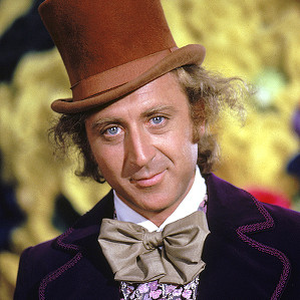

In [28]:
#loading content image
content_filename="willy_wonka_old.jpg"
content_image=load_image(content_filename,max_size=300)
plot_image_big(content_image)

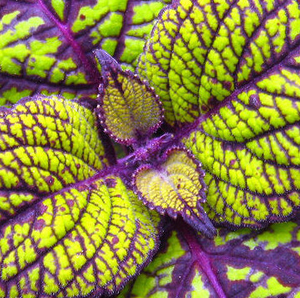

In [29]:
#loading style image
style_filename="style7.jpg"
style_image=load_image(style_filename,max_size=300)
plot_image_big(style_image)

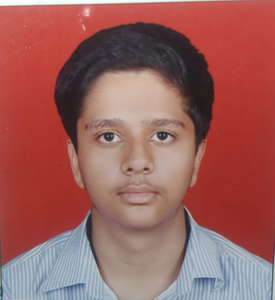

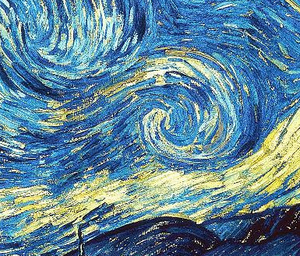

In [31]:
#loading content image
content_filename="WhatsApp Image 2019-03-18 at 3.07.12 PM.jpeg"
content_image1=load_image(content_filename,max_size=300)
plot_image_big(content_image1)

#loading style image
style_filename="style2.jpg"
style_image1=load_image(style_filename,max_size=300)
plot_image_big(style_image1)

In [0]:
#Then we define a list of integers which identify the layers in the neural network that we want to use for matching the content-image.
#These are indices into the layers in the neural network.
#For the VGG16 model, the 5th layer (index 4) seems to work well as the sole content-layer.

content_layer_ids=[4]

In [0]:
#Then we define another list of integers for the style-layers

# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.

style_layer_ids=list(range(13))




W0618 03:50:59.491728 140171525359488 deprecation.py:323] From /content/vgg16.py:107: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0618 03:50:59.493480 140171525359488 deprecation_wrapper.py:119] From /content/vgg16.py:110: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



Content Layers
['conv3_1/conv3_1']

Style Layers
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
iterations: 0
weight adj. for content:9.026469e-11, style:3.271365e-29, denoise:6.087012e-06


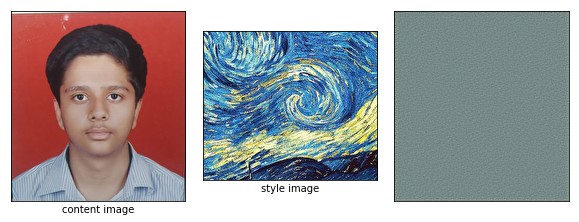

. . . . . . . . . . 
iterations: 10
weight adj. for content:3.085401e-11, style:8.193188e-28, denoise:7.706555e-08


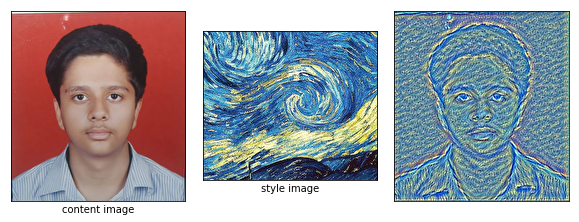

. . . . . . . . . . 
iterations: 20
weight adj. for content:2.626113e-11, style:7.483895e-28, denoise:6.852283e-08


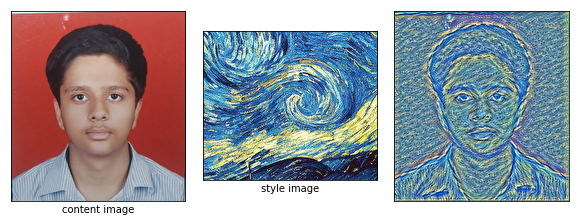

. . . . . . . . . . 
iterations: 30
weight adj. for content:2.606844e-11, style:7.969569e-28, denoise:6.713611e-08


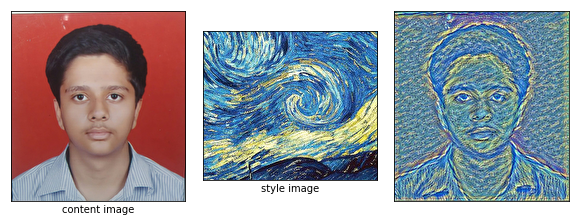

. . . . . . . . . . 
iterations: 40
weight adj. for content:2.584512e-11, style:8.051242e-28, denoise:6.588893e-08


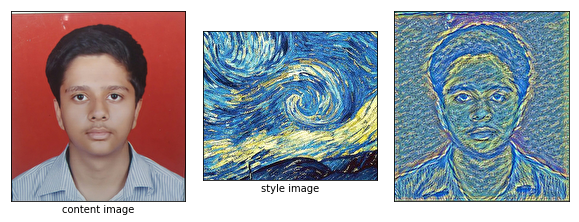

. . . . . . . . . . 
iterations: 50
weight adj. for content:2.565853e-11, style:7.948111e-28, denoise:6.468915e-08


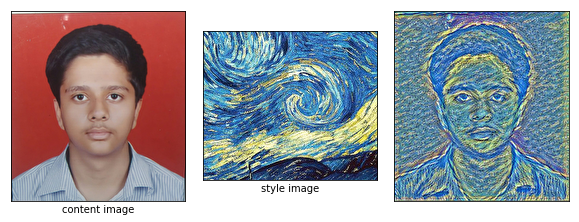

. . . . . . . . . . 
iterations: 60
weight adj. for content:2.546801e-11, style:7.676099e-28, denoise:6.357246e-08


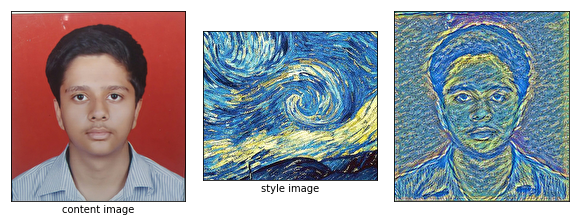

. . . . . . . . . . 
iterations: 70
weight adj. for content:2.529590e-11, style:7.336430e-28, denoise:6.250826e-08


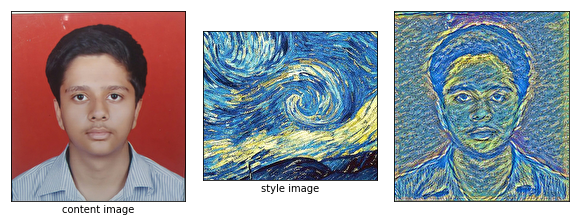

. . . . . . . . . . 
iterations: 80
weight adj. for content:2.515825e-11, style:7.043827e-28, denoise:6.156043e-08


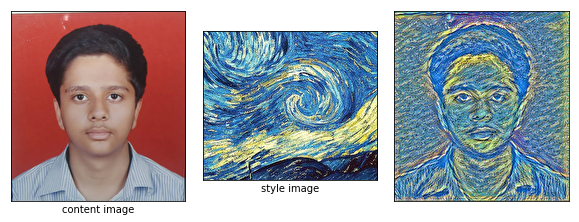

. . . . . . . . . . 
iterations: 90
weight adj. for content:2.504871e-11, style:6.747563e-28, denoise:6.070983e-08


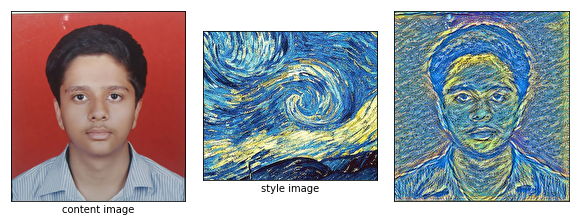

. . . . . . . . . . 
iterations: 100
weight adj. for content:2.495090e-11, style:6.475933e-28, denoise:5.992265e-08


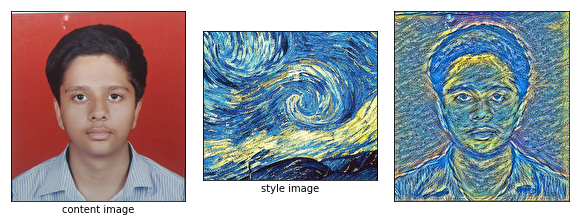

. . . . . . . . . . 
iterations: 110
weight adj. for content:2.486016e-11, style:6.258479e-28, denoise:5.923506e-08


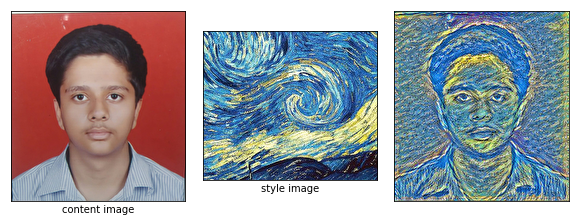

. . . . . . . . . 
iterations: 119
weight adj. for content:3.453356e-11, style:1.763143e-27, denoise:7.393796e-08


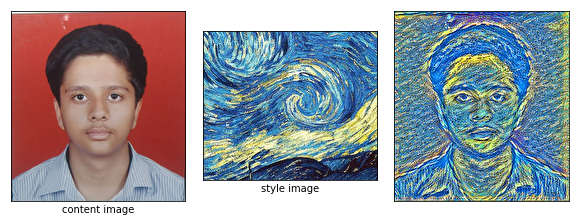


final image:


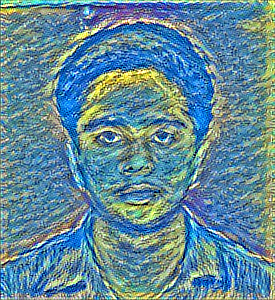

In [34]:
#Now perform the style-transfer

img=style_transfer_algorithm(content_image=content_image1,style_image=style_image1,content_layer_ids=content_layer_ids,style_layer_ids=style_layer_ids,weight_content=1.5,weight_style=10.0,weight_denoise=0.3,num_iterations=120,step_size=10.0)
